# Project 3
## David Grubman

In this project, you will perform a logistic regression on the admissions data we've been working with in projects 1 and 2.

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import pylab as pl
import numpy as np


In [29]:
df_raw = pd.read_csv("admissions.csv")
df = df_raw.dropna() 
print df.head()

   admit    gre   gpa  prestige
0      0  380.0  3.61       3.0
1      1  660.0  3.67       3.0
2      1  800.0  4.00       1.0
3      1  640.0  3.19       4.0
4      0  520.0  2.93       4.0


## Part 1. Frequency Tables

#### 1. Let's create a frequency table of our variables

In [30]:
# frequency table for prestige and whether or not someone was admitted
df_prestige_raw = df[['admit','prestige']]
df_prestige_raw.groupby('prestige').count()

#I know i could use crosstab (see below) but I wanted to get fancy with groupby

,admit
prestige,
1.0,61
2.0,148
3.0,121
4.0,67


## Part 2. Return of dummy variables

#### 2.1 Create class or dummy variables for prestige 

In [31]:
df_with_dummies= pd.get_dummies(df, prefix='Prestige', columns=['prestige'])

df_with_dummies.head(5)

,admit,gre,gpa,Prestige_1.0,Prestige_2.0,Prestige_3.0,Prestige_4.0
0,0,380.0,3.61,0,0,1,0
1,1,660.0,3.67,0,0,1,0
2,1,800.0,4.00,1,0,0,0
3,1,640.0,3.19,0,0,0,1
4,0,520.0,2.93,0,0,0,1


#### 2.2 When modeling our class variables, how many do we need? 



Answer: We need n-1 of our class variables. We cannot use all four variables.

## Part 3. Hand calculating odds ratios

Develop your intuition about expected outcomes by hand calculating odds ratios.

In [32]:
cols_to_keep = ['admit', 'gre', 'gpa']
dummy_ranks = pd.get_dummies(df.prestige,prefix='prestige')

handCalc = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_1':])
handCalc.rename(columns={'prestige_1.0': 'prestige_1','prestige_2.0': 'prestige_2','prestige_3.0': 'prestige_3','prestige_4.0': 'prestige_4'}, inplace=True)
print handCalc.head()

   admit    gre   gpa  prestige_1  prestige_2  prestige_3  prestige_4
0      0  380.0  3.61           0           0           1           0
1      1  660.0  3.67           0           0           1           0
2      1  800.0  4.00           1           0           0           0
3      1  640.0  3.19           0           0           0           1
4      0  520.0  2.93           0           0           0           1


In [33]:
#crosstab prestige 1 admission 
# frequency table cutting prestige and whether or not someone was admitted
pd.crosstab(handCalc.prestige_1, handCalc.admit, margins=True)

admit,0,1,All
prestige_1,,,
0,243,93,336
1,28,33,61
All,271,126,397


#### 3.1 Use the cross tab above to calculate the odds of being admitted to grad school if you attended a #1 ranked college

In [34]:
#yeah, i'm stealing your code.
prob_1 = 33/float(61) #when dividing integers, make sure you convert to float first. Otherwise, 1/5 will return 1, not .2
odds_ratio_1 =  prob_1 / (1-prob_1)
log_odds_1 = np.log(odds_ratio_1)

print "Probability 1:", prob_1
print "Odds Ratio 1:", odds_ratio_1
print "Log Odds Ratio 1:", log_odds_1

Probability 1: 0.540983606557
Odds Ratio 1: 1.17857142857
Log Odds Ratio 1: 0.164303051291


#### 3.2 Now calculate the odds of admission if you did not attend a #1 ranked college

In [35]:
prob_2 = 93/float(336) #when dividing integers, make sure you convert to float first. Otherwise, 1/5 will return 1, not .2
odds_ratio_2 =  prob_2 / (1-prob_2)
log_odds_2 = np.log(odds_ratio_2)

print "Probability 2 :", prob_2
print "Odds Ratio 2 : ", odds_ratio_2
print "Log Odds Ratio 2:", log_odds_2

Probability 2 : 0.276785714286
Odds Ratio 2 :  0.382716049383
Log Odds Ratio 2: -0.960461950187


#### 3.3 Calculate the odds ratio

In [36]:
#See above: 
oddsratio_final = odds_ratio_1 / odds_ratio_2
oddsratio_final

3.079493087557604

#### 3.4 Write this finding in a sentenance: 

Answer: A student with a Prestige 1 is 3.07 times more likely to attend a number one college, than someone who didn't.

#### 3.5 Print the cross tab for prestige_4

In [37]:
pd.crosstab(handCalc.prestige_4, handCalc.admit, margins=True)

admit,0,1,All
prestige_4,,,
0,216,114,330
1,55,12,67
All,271,126,397


#### 3.6 Calculate the OR 

In [38]:
#calculate the odds ratio between 114/ 330 v 12/ 67
prob_no_prestige4 = 114/float(330) 
odds_no_prestige4 =  prob_no_prestige4 / (1-prob_no_prestige4)
prob_prestige4 = 12/float(67)
odds_prestige4 =  prob_prestige4 / (1-prob_prestige4)


print "Probability No Prestige 4 :", prob_no_prestige4
print "Odds Ratio No Prestige 4 : ", odds_no_prestige4

print "Probability with Prestige 4 :", prob_prestige4
print "Odds Ratio with Prestige 4 : ", odds_prestige4

print "The or is :", odds_no_prestige4 / float(odds_prestige4)


Probability No Prestige 4 : 0.345454545455
Odds Ratio No Prestige 4 :  0.527777777778
Probability with Prestige 4 : 0.179104477612
Odds Ratio with Prestige 4 :  0.218181818182
The or is : 2.41898148148


#### 3.7 Write this finding in a sentence

Answer: You are 2.41 times more likely to get admitted with a prestige ranking of 1 , 2, or 3 than you are with a prestige ranking of 4. 

(I know there are other ways of answering this question, but this seemed the most easily explained.)

## Part 4. Analysis

In [39]:
# create a clean data frame for the regression
cols_to_keep = ['admit', 'gre', 'gpa']
data = df[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])
data.rename(columns={'prestige_2.0': 'prestige_2','prestige_3.0': 'prestige_3','prestige_4.0': 'prestige_4'}, inplace=True)
print data.head()

   admit    gre   gpa  prestige_2  prestige_3  prestige_4
0      0  380.0  3.61           0           1           0
1      1  660.0  3.67           0           1           0
2      1  800.0  4.00           0           0           0
3      1  640.0  3.19           0           0           1
4      0  520.0  2.93           0           0           1


We're going to add a constant term for our Logistic Regression. The statsmodels function we're going to be using requires that intercepts/constants are specified explicitly.

In [40]:
# manually add the intercept
data['intercept'] = 1.0

#### 4.1 Set the covariates to a variable called train_cols

In [41]:
trains_cols =['gre', 'gpa', 'prestige_2','prestige_3','prestige_4','intercept']

#### 4.2 Fit the model

In [42]:
X=data[trains_cols]
y=data['admit']
log_lm = sm.Logit(y, X)
result = log_lm.fit()


Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


#### 4.3 Print the summary results

In [52]:
df_results = result.summary()
df_results

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  admit   No. Observations:                  397
Model:                          Logit   Df Residuals:                      391
Method:                           MLE   Df Model:                            5
Date:                Mon, 17 Apr 2017   Pseudo R-squ.:                 0.08166
Time:                        21:00:32   Log-Likelihood:                -227.82
converged:                       True   LL-Null:                       -248.08
                                        LLR p-value:                 1.176e-07
==============================================================================
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
gre            0.0022      0.001      2.028      0.043      7.44e-05     0.004
gpa            0.7793      0.333      2.344      0.019         0.128     1.431
prestige_2    -0.6801      0.317     -2.146      0.032        -1.301    -0.059
prestige_3    -1.3387      0.345     -3.882      0.000        -2.015    -0.663
prestige_4    -1.5534      0.417     -3.721      0.000        -2.372    -0.735
intercept     -3.8769      1.142     -3.393      0.001        -6.116    -1.638
==============================================================================
"""

#### 4.4 Calculate the odds ratios of the coeffiencents and their 95% CI intervals

hint 1: np.exp(X)

hint 2: conf['OR'] = params
        
           conf.columns = ['2.5%', '97.5%', 'OR']

In [44]:
np.exp(result.params)

gre           1.002221
gpa           2.180027
prestige_2    0.506548
prestige_3    0.262192
prestige_4    0.211525
intercept     0.020716
dtype: float64

In [45]:
conf = result.conf_int()
params = result.params
conf['OR'] = params
conf.columns = ['2.5%', '97.5%', 'OR']
print np.exp(conf)


                2.5%     97.5%        OR
gre         1.000074  1.004372  1.002221
gpa         1.136120  4.183113  2.180027
prestige_2  0.272168  0.942767  0.506548
prestige_3  0.133377  0.515419  0.262192
prestige_4  0.093329  0.479411  0.211525
intercept   0.002207  0.194440  0.020716


#### 4.5 Interpret the OR of Prestige_2

Answer: With a prestige rating of 2, you are 50.6 percent more likely to be admitted. 

#### 4.6 Interpret the OR of GPA

Answer: For every point higher in GPA, you are 2.18 times more likely to be admitted.

## Part 5: Predicted probablities


As a way of evaluating our classifier, we're going to recreate the dataset with every logical combination of input values. This will allow us to see how the predicted probability of admission increases/decreases across different variables. First we're going to generate the combinations using a helper function called cartesian (above).

We're going to use np.linspace to create a range of values for "gre" and "gpa". This creates a range of linearly spaced values from a specified min and maximum value--in our case just the min/max observed values.

In [46]:
def cartesian(arrays, out=None):
    """
    Generate a cartesian product of input arrays.
    Parameters
    ----------
    arrays : list of array-like
        1-D arrays to form the cartesian product of.
    out : ndarray
        Array to place the cartesian product in.
    Returns
    -------
    out : ndarray
        2-D array of shape (M, len(arrays)) containing cartesian products
        formed of input arrays.
    Examples
    --------
    >>> cartesian(([1, 2, 3], [4, 5], [6, 7]))
    array([[1, 4, 6],
           [1, 4, 7],
           [1, 5, 6],
           [1, 5, 7],
           [2, 4, 6],
           [2, 4, 7],
           [2, 5, 6],
           [2, 5, 7],
           [3, 4, 6],
           [3, 4, 7],
           [3, 5, 6],
           [3, 5, 7]])
    """

    arrays = [np.asarray(x) for x in arrays]
    dtype = arrays[0].dtype

    n = np.prod([x.size for x in arrays])
    if out is None:
        out = np.zeros([n, len(arrays)], dtype=dtype)

    m = n / arrays[0].size
    out[:,0] = np.repeat(arrays[0], m)
    if arrays[1:]:
        cartesian(arrays[1:], out=out[0:m,1:])
        for j in xrange(1, arrays[0].size):
            out[j*m:(j+1)*m,1:] = out[0:m,1:]
    return out

In [47]:
# instead of generating all possible values of GRE and GPA, we're going
# to use an evenly spaced range of 10 values from the min to the max 
gres = np.linspace(data['gre'].min(), data['gre'].max(), 10)
print gres
# array([ 220.        ,  284.44444444,  348.88888889,  413.33333333,
#         477.77777778,  542.22222222,  606.66666667,  671.11111111,
#         735.55555556,  800.        ])
gpas = np.linspace(data['gpa'].min(), data['gpa'].max(), 10)
print gpas
# array([ 2.26      ,  2.45333333,  2.64666667,  2.84      ,  3.03333333,
#         3.22666667,  3.42      ,  3.61333333,  3.80666667,  4.        ])


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))
combos.tail(4)

[ 220.          284.44444444  348.88888889  413.33333333  477.77777778
  542.22222222  606.66666667  671.11111111  735.55555556  800.        ]
[ 2.26        2.45333333  2.64666667  2.84        3.03333333  3.22666667
  3.42        3.61333333  3.80666667  4.        ]


,0,1,2,3
396,800.0,4.0,1.0,1.0
397,800.0,4.0,2.0,1.0
398,800.0,4.0,3.0,1.0
399,800.0,4.0,4.0,1.0


#### 5.1 Recreate the dummy variables

In [48]:
# recreate the dummy variables. I like to start with a fresh set.
df_raw = pd.read_csv("admissions.csv")
df_cart = df_raw.dropna() 
cols_to_keep = ['admit', 'gre', 'gpa']
df_cart = df_cart[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_1':])
df_cart.rename(columns={'prestige_1.0': 'prestige_1','prestige_2.0': 'prestige_2','prestige_3.0': 'prestige_3','prestige_4.0': 'prestige_4'}, inplace=True)
df_cart.head(5)
# keep only what we need for making predictions


,admit,gre,gpa,prestige_1,prestige_2,prestige_3,prestige_4
0,0,380.0,3.61,0,0,1,0
1,1,660.0,3.67,0,0,1,0
2,1,800.0,4.00,1,0,0,0
3,1,640.0,3.19,0,0,0,1
4,0,520.0,2.93,0,0,0,1


#### 5.2 Make predictions on the enumerated dataset

In [49]:
train_cols =['gre', 'gpa', 'prestige_2','prestige_3','prestige_4','intercept']
df_cart['intercept'] = 1.0
X=df_cart[trains_cols]
y=df_cart['admit']
log_lm = sm.Logit(y, X)
result = log_lm.fit()

#rename combos
# recreate the dummy variables


# enumerate all possibilities
combos = pd.DataFrame(cartesian([gres, gpas, [1, 2, 3, 4], [1.]]))
# recreate the dummy variables
combos.columns = ['gre', 'gpa', 'prestige', 'intercept']
dummy_ranks = pd.get_dummies(combos['prestige'], prefix='prestige')
dummy_ranks.columns = ['prestige_1', 'prestige_2', 'prestige_3', 'prestige_4']

# keep only what we need for making predictions
cols_to_keep = ['gre', 'gpa', 'prestige', 'intercept']
combos = combos[cols_to_keep].join(dummy_ranks.ix[:, 'prestige_2':])

combos['admit_pred'] = result.predict(combos[train_cols])
combos.tail(4)

Optimization terminated successfully.
         Current function value: 0.573854
         Iterations 6


,gre,gpa,prestige,intercept,prestige_2,prestige_3,prestige_4,admit_pred
396,800.0,4.0,1.0,1.0,0,0,0,0.734040
397,800.0,4.0,2.0,1.0,1,0,0,0.582995
398,800.0,4.0,3.0,1.0,0,1,0,0.419833
399,800.0,4.0,4.0,1.0,0,0,1,0.368608


#### 5.3 Interpret findings for the last 4 observations

Answer: The higher the prestige, the more likely you are to be admitted. With all things equal we can see a higher probability of admission based on the prestige ranking of the undergraduate university.

## Bonus

Plot the probability of being admitted into graduate school, stratified by GPA and GRE score.

In [57]:
#i didnt have time to get to this but i'd like to see the answer!
import seaborn as sns
len(combos)

400

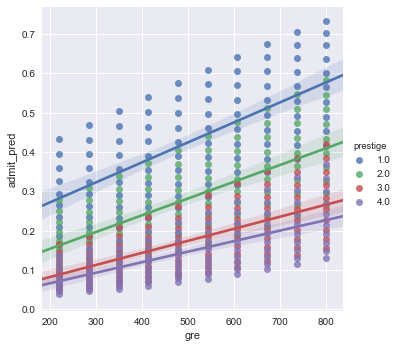

In [62]:
sns.lmplot(x="gre", y="admit_pred", data=combos, hue='prestige')

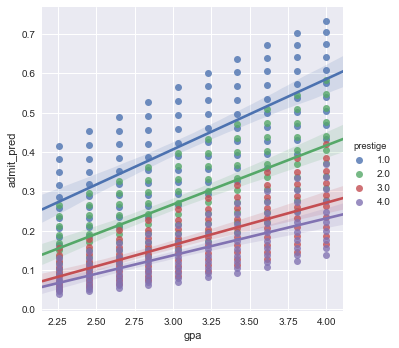

In [60]:
sns.lmplot(x="gpa", y="admit_pred", data=combos, hue='prestige')